In [1]:
import os

from helpers.DatasetProcess import dataset_to_df
from helpers.PlotExtension import norm_to_plot, img_plot
from helpers.WaveletPacketV3 import wpt_dec, plot_wpt_nodes, plot_wpt_fun

#
import ptwt

import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sn


import torch
from torch import nn
import torch.nn.functional as F


# The cross-entropy loss penalizes the model more when it is more confident in the incorrect class
from torch.nn import CrossEntropyLoss

# Adam is an optimization algorithm that can be used instead of the classical SGD procedure
# to update network weights iterative based in training data.
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import v2
from torchvision.io import read_image

from torchinfo import summary

from einops import rearrange, repeat
from einops.layers.torch import Rearrange


from sklearn.metrics import confusion_matrix, roc_curve

In [2]:
print(f"torch version: {torch.__version__}")
print(f"GPU Card: {torch.cuda.get_device_name(0)}")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Torch is using device:', device)
torch.cuda.get_device_name(device)

NUM_WORKERS = os.cpu_count()
print("CPU Count:", NUM_WORKERS)

torch version: 2.2.1+cu121
GPU Card: NVIDIA GeForce RTX 3070 Ti Laptop GPU
Torch is using device: cuda:0
CPU Count: 20


In [3]:
path = '../../../data/CIFAK'
relative_paths = ["/train/REAL", "/train/FAKE", "/test/REAL", "/test/FAKE"]
paths_classes = ["REAL", "FAKE", "REAL", "FAKE"]

classes = list(set(paths_classes))
classes.sort()
classes

['FAKE', 'REAL']

In [4]:
try:
    df_all = pd.read_csv(f'{path}/df_all.csv')
    df_train = pd.read_csv(f'{path}/df_train.csv')
    df_val = pd.read_csv(f'{path}/df_val.csv')
    df_test = pd.read_csv(f'{path}/df_test.csv')
    classes_stats = pd.read_csv(f'{path}/classes_stats.csv')
except FileNotFoundError:
    df_all, df_train, df_val, df_test, classes_stats = dataset_to_df(
        path, relative_paths, paths_classes, 0.8, 0.14, 0.06)
    df_all.to_csv(f'{path}/df_all.csv', index=False)
    df_train.to_csv(f'{path}/df_train.csv', index=False)
    df_val.to_csv(f'{path}/df_val.csv', index=False)
    df_test.to_csv(f'{path}/df_test.csv', index=False)
    classes_stats.to_csv(f'{path}/classes_stats.csv')

classes_stats

,Unnamed: 0,REAL,FAKE,Total
0,Training,48000,48000,96000
1,Validation,8400,8400,16800
2,Testing,3600,3600,7200
3,Row_Total,60000,60000,120000


In [5]:
df_all.iloc[[0, -1]]

,Image_path,Height,Width,Channels,Class,Class_Codes,Class_Onehot
0,../../../data/CIFAK//train/REAL/0000(10).jpg,32,32,RGB,REAL,1,[1 0]
119999,../../../data/CIFAK//test/FAKE/999.jpg,32,32,RGB,FAKE,0,[0 1]


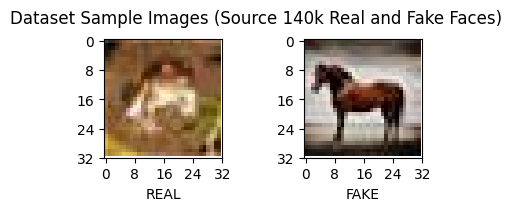

In [6]:
r_img_idx, f_img_idx = 6, -3
step = 8


fig, axs = plt.subplots(1, 2, layout="constrained", figsize=(4, 2))
fig.suptitle('Dataset Sample Images (Source 140k Real and Fake Faces)')

r_img = plt.imread(df_all.iloc[r_img_idx, 0])
f_img = plt.imread(df_all.iloc[f_img_idx, 0])

axs[0].imshow(r_img)
axs[0].set(xlabel=df_all.iloc[r_img_idx, 4])
axs[0].set(xticks=np.arange(0, r_img.shape[1]+1, step=step),
           yticks=np.arange(0, r_img.shape[0]+1, step=step))

axs[1].imshow(f_img)
axs[1].set(xlabel=df_all.iloc[f_img_idx, 4])
axs[1].set(xticks=np.arange(0, f_img.shape[1]+1, step=step),
           yticks=np.arange(0, f_img.shape[0]+1, step=step))

plt.show()

In [7]:
training_phase = 1

In [8]:
model_type = "vit"
add_extra_epochs = True  # if True then continue for extra epochs from the starting epoch

# If True load a pretrained model, and start_epoch = epoch of the model . Else if False then start_epoch = 0
start_from_model = False
continue_lr=True

In [10]:
model_state_path = f"../../../weights/{model_type}_wpt_cifak/checkpoint2/"

# file name of the saved model

# model_file_name = f"vit_wpt_cifak_ph1_Epoch96_acc92.81"

# checkpoint = torch.load(model_state_path+model_file_name)

In [11]:
if start_from_model:
    training_phase_lst = checkpoint['training_phase_lst']
    training_phase = training_phase_lst[-1]+1
    
print(training_phase)

1


In [12]:
# Wavelet Packet Transform Hyper Parameters
wpt_fun = 'haar'
wpt_level = 2
features = ((2**wpt_level)**2)  # 16 for level 2
channels = len(df_all.iloc[0, 3])
print(channels)

3


In [13]:
img_trans_norm_mean = [0.4913997551666284,
                       0.48215855929893703, 0.4465309133731618]
img_trans_norm_std = [0.24703225141799082,
                      0.24348516474564, 0.26158783926049628]

In [14]:
in_img_size = int(df_all.iloc[0, 1])
# Input image height/width in pixels
wpt_img_size = int(in_img_size/(2**wpt_level))
# The height/width of a patch in pixels (patch is a slice of an image)
patch_size = 4

# 16 Channels x Patch_height**2
image_patch_flat_size = (channels) * patch_size**2
embed_size = image_patch_flat_size
# embed_size = features * image_patch_flat_size
mlp_dim = 384  # dim of the last mlp classifier

train_batch_size = 512  # https://www.youtube.com/watch?v=Owm1H0ukjS4
valid_batch_size = 512
test_batch_size = 400

num_classes = 2
encoder_depth = 2
attention_heads = 16

print(f'Flattened dimension size(of a patch): {image_patch_flat_size}')
print(f'Embedding Size: {embed_size}')
print(f'Output MLP size: {mlp_dim}')

Flattened dimension size(of a patch): 48
Embedding Size: 48
Output MLP size: 384


In [15]:
n_extra_epochs = 110
max_epochs = 200

start_epoch = checkpoint['epoch']+1 if start_from_model else 0
end_epoch = start_epoch + n_extra_epochs if add_extra_epochs else max_epochs
delta_epochs = end_epoch-start_epoch

print(f"Train another {delta_epochs} epochs after epoch {start_epoch} ")

Train another 110 epochs after epoch 0 


In [16]:
base_lr = 0.1         # Base Learning rate 0.1 for SGD , 0.0001 for Adam
momentum = 0.9          # Momentum for SGD
weight_decay = 0.001     # Weight decay for Adam

if start_from_model & continue_lr:
    use_lr= checkpoint['running_lr_lst'][-1]
else:
    use_lr=base_lr



loss_algo = CrossEntropyLoss

optimize_algo = SGD  # Adam
optimize_args = {"lr": use_lr,
                 #  "weight_decay": weight_decay ,
                 "momentum": momentum
                 }

use_scheduler = True
schedule_algo = ReduceLROnPlateau
schedule_args = {"factor": 0.5, "mode": "max"}  # , "verbose": True}

In [17]:
hyper_parameters = {
    "training_phase": training_phase,
    "model_type": model_type,
    "wpt_fun": wpt_fun,
    "wpt_level": wpt_level,
    "channels": channels,
    "img_trans_norm_mean": img_trans_norm_mean,
    "img_trans_norm_std": img_trans_norm_std,
    "in_img_size": in_img_size,
    "wpt_img_size": wpt_img_size,
    "patch_size": patch_size,
    "image_patch_flat_size": image_patch_flat_size,
    "embed_size": embed_size,
    "mlp_dim": mlp_dim,
    "train_batch_size": train_batch_size,
    "valid_batch_size": valid_batch_size,
    "num_classes": num_classes,
    "encoder_depth": encoder_depth,
    "attention_heads": attention_heads,
    "n_extra_epochs ": n_extra_epochs,
    "base_lr": base_lr,
    "momentum": momentum,
    "weight_decay": weight_decay,
    "loss_algo": loss_algo,
    "optimize_algo": optimize_algo,
    "optimize_args": optimize_args,
    "use_scheduler": use_scheduler,
    "schedule_algo": schedule_algo,
    "schedule_args": schedule_args
}

hyper_parameters

{'training_phase': 1,
 'model_type': 'vit',
 'wpt_fun': 'haar',
 'wpt_level': 2,
 'channels': 3,
 'img_trans_norm_mean': [0.4913997551666284,
  0.48215855929893703,
  0.4465309133731618],
 'img_trans_norm_std': [0.24703225141799082,
  0.24348516474564,
  0.2615878392604963],
 'in_img_size': 32,
 'wpt_img_size': 8,
 'patch_size': 4,
 'image_patch_flat_size': 48,
 'embed_size': 48,
 'mlp_dim': 384,
 'train_batch_size': 512,
 'valid_batch_size': 512,
 'num_classes': 2,
 'encoder_depth': 2,
 'attention_heads': 16,
 'n_extra_epochs ': 110,
 'base_lr': 0.1,
 'momentum': 0.9,
 'weight_decay': 0.001,
 'loss_algo': torch.nn.modules.loss.CrossEntropyLoss,
 'optimize_algo': torch.optim.sgd.SGD,
 'optimize_args': {'lr': 0.1, 'momentum': 0.9},
 'use_scheduler': True,
 'schedule_algo': torch.optim.lr_scheduler.ReduceLROnPlateau,
 'schedule_args': {'factor': 0.5, 'mode': 'max'}}

In [18]:
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py
# replaced the attention mechanism with MHA from Sebastian Raschka

# helpers
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes


class WPT2D(nn.Module):
    def __init__(self, wpt_fun, wpt_level, mode='boundary'):
        super().__init__()
        self.wpt_fun = wpt_fun
        self.wpt_level = wpt_level
        self.mode = mode

    def forward(self, x):

        ptwp = ptwt.WaveletPacket2D(
            x, self.wpt_fun, mode=self.mode, maxlevel=self.wpt_level)
        paths_keys = [key for key in ptwp if len(key) == self.wpt_level]
        nodes = [ptwp[path].unsqueeze(1) for path in paths_keys]
        nodes_tensor = torch.cat(nodes, dim=1)

        return nodes_tensor


class Patch_Embed(nn.Module):
    def __init__(self, patch_height, patch_width, patch_dim, embed_dim):
        super().__init__()
        self.patch_embed = nn.Sequential(
            # This rearrangement is suitable for the wavelet packet features
            # torch.Size([200, 16, 3, 32, 32])
            Rearrange('b f c (h p1) (w p2) -> b (f h w) (c p1 p2)',
                      p1=patch_height, p2=patch_width),
            nn.Linear(patch_dim, embed_dim),
        )

    def forward(self, x):
        return self.patch_embed(x)


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.model(x)


# inspired by Sebstian Raschka with modifications
class MHA(nn.Module):
    def __init__(self, embed_dim: int, num_of_head: int = 12, Dropout=0.2) -> None:
        super().__init__()
        self.embed_dim = embed_dim
        self.inner_dim = embed_dim*2
        self.num_of_head = num_of_head
        self.dim_per_head = self.inner_dim // self.num_of_head
        self.Wq = nn.Linear(in_features=embed_dim, out_features=self.inner_dim)
        self.Wk = nn.Linear(in_features=embed_dim, out_features=self.inner_dim)
        self.Wv = nn.Linear(in_features=embed_dim, out_features=self.inner_dim)
        self.softmax=nn.Softmax(dim=-1)

        self.dropout = Dropout
        self.linear = nn.Linear(
            in_features=self.inner_dim, out_features=embed_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        q = self.Wq(x)
        k = self.Wk(x)
        v = self.Wv(x)

        Q = rearrange(q, 'b s (h d) -> b h s d',
                      h=self.num_of_head, d=self.dim_per_head)
        K = rearrange(k, 'b s (h d) -> b h s d',
                      h=self.num_of_head, d=self.dim_per_head)
        V = rearrange(v, 'b s (h d) -> b h s d',
                      h=self.num_of_head, d=self.dim_per_head)

        scale_factor = self.dim_per_head**0.5

        use_dropout = 0.0 if not self.training else self.dropout

        # Note:

        # # Q(b h s d) . KT(b h d s) ==> b h s s
        QK = Q @ K.transpose(-2, -1) * scale_factor

        # # b h s s ==> b h s s
        # weight = F.softmax(QK, dim=-1)
        weight = self.softmax(QK)
        weight = torch.dropout(weight, use_dropout, train=True)

        # # weight(b h s s).V(b h s d) ==> attention (b h s d)
        attention = weight @ V

        attention = rearrange(attention, 'b h s d -> b s (h d)')
        attention = self.linear(attention)
        return attention


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()

        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(
                nn.ModuleList(
                    [PreNorm(dim, MHA(embed_dim=dim, num_of_head=heads, Dropout=dropout)),
                     PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout))]
                )
            )

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class vit(nn.Module):
    def __init__(self, *, image_size, patch_size, wpt_fun, wpt_level, features, num_classes, dim, depth, heads, mlp_dim, pool='cls', channels=3, dim_head=64, emb_dropout=0., dropout=0.):
        super().__init__()

        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = features * \
            (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        assert pool in {
            'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_wpt2d = WPT2D(wpt_fun, wpt_level, mode='boundary')
        self.to_patch_embedding = Patch_Embed(
            patch_height, patch_width, patch_dim, dim)

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(
            dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        # print(img.shape)
        img_wpt = self.to_wpt2d(img)
        # print(img_wpt.shape)
        x = self.to_patch_embedding(img_wpt)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim=1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [21]:
# Custom Dataset Class
class Images_Dataset(Dataset):
    def __init__(self, annotations_df, transform=None):

        self.annotation = annotations_df
        self.transform = transform

    def __getitem__(self, index):

        img = read_image(self.annotation.iloc[index, 0])
        labels = torch.tensor(
            self.annotation.iloc[index, 5], dtype=torch.int64)

        if self.transform:
            img_t = self.transform(img)
        else:
            img_t = img

        return img_t, labels

    def __len__(self):
        # To return the length of the dataset
        return self.annotation.shape[0]

In [22]:
transform_train = transforms.Compose([
    # Note:
    # We want to introduce augmentation for the dataset using transformations
    # which doesn't change the real images into fake
    # v2.CenterCrop(size=in_img_size),
    # v2.Resize(size=int(in_img_size/2)),
    transforms.ToPILImage(),
    # v2.RandomAffine(degrees=(-90, 90), translate=(0.1, 0.3), scale=(0.75, 1)),
    # transforms.ToTensor(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(img_trans_norm_mean, img_trans_norm_std),
])

transform_valid = transforms.Compose([
    # transforms.ToTensor(),
    # v2.CenterCrop(size=in_img_size),
    # v2.Resize(size=int(in_img_size/2)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(img_trans_norm_mean, img_trans_norm_std),
])

In [23]:
# Define the dataset object and configure the Data Loader

train_set = Images_Dataset(df_train, transform_train)

train_loader = DataLoader(dataset=train_set,
                          batch_size=train_batch_size,
                          # Drops the last mini batch if less than the batch size (could enhance the model accuracy)
                          drop_last=True,
                          shuffle=True,
                          pin_memory=True,
                          num_workers=NUM_WORKERS)


valid_set = Images_Dataset(df_val, transform_valid)

valid_loader = DataLoader(dataset=valid_set,
                          batch_size=valid_batch_size,
                          # Drops the last mini batch if less than the batch size (could enhance the model accuracy)
                          drop_last=True,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=NUM_WORKERS)

In [24]:
print("Total number of training batches:", len(train_loader))
print("Total number of validation batches:", len(valid_loader))

Total number of training batches: 187
Total number of validation batches: 32


In [25]:
sample_imgt_bch, label_bch = next(iter(train_loader))

In [26]:
print(f"Batch of Images Shape: {sample_imgt_bch.size()}")
print(f"Batch of Labels Shape: {label_bch.size()}")
# print(label_bch)

Batch of Images Shape: torch.Size([512, 3, 32, 32])
Batch of Labels Shape: torch.Size([512])


In [27]:
sample_img_idx = 12

sample_img = sample_imgt_bch[sample_img_idx, :, :, :]

In [28]:
sample_img_a, nodes, * \
    _, wp_fun, wp_name, _, _ = wpt_dec(sample_img, wpt_fun, wpt_level)
sample_img_a.shape

(32, 32, 3)

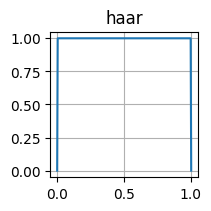

In [29]:
plot_wpt_fun(sample_img, wpt_fun, wpt_level)

Text(0.5, 1.0, 'Label: Real')

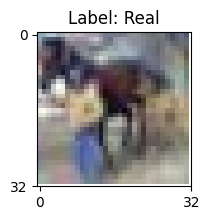

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))

ax.imshow(norm_to_plot(sample_img_a)[1])
ax.set(xticks=np.arange(0, sample_img_a.shape[1]+1, step=32),
       yticks=np.arange(0, sample_img_a.shape[0]+1, step=32))
ax.set_title(
    f'Label: {"Real" if label_bch[sample_img_idx].item()==1 else "Fake"}')

/home/osmahus/pytVenv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/home/osmahus/pytVenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


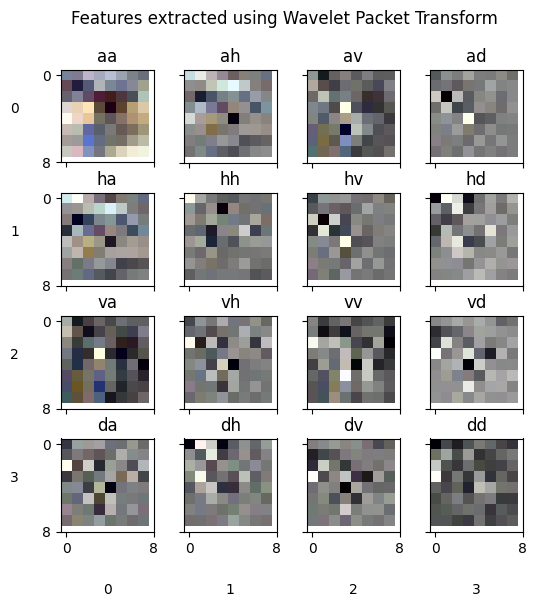

In [31]:
plot_wpt_nodes(sample_img, wpt_fun, wpt_level,
               setticks1=8, setticks2=8, figsize=(6, 6))

Shape of the image patches matrix:  (2, 2, 4, 4, 3)


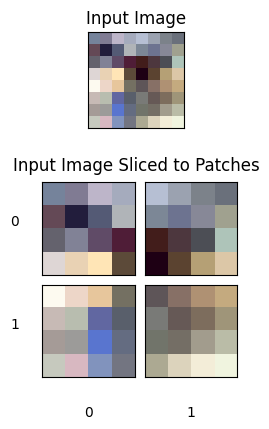

In [32]:
img_plot(plt, nodes[0, :, :, :], patch_size,
         CHW_Image=False, figsize=(3, 4), axes_pad=0.1)

Shape of the image patches matrix:  (2, 2, 4, 4, 3)


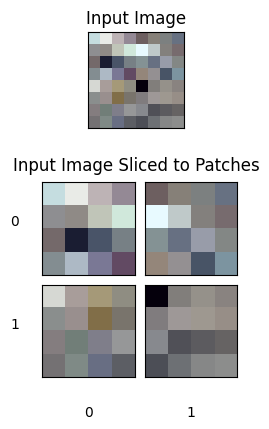

In [33]:
img_plot(plt, nodes[1, :, :, :], patch_size,
         CHW_Image=False, figsize=(3, 4), axes_pad=0.1)

In [34]:
if model_type == "vit":
    model = vit(
        image_size=wpt_img_size,
        patch_size=patch_size,
        features=features,
        wpt_fun=wpt_fun,
        wpt_level=wpt_level,
        num_classes=num_classes,
        dim=embed_size,
        depth=encoder_depth,
        heads=attention_heads,
        mlp_dim=mlp_dim,
        emb_dropout=0.1,
        dropout=0.1,
        channels=channels
    )
else:
    raise ValueError(
        "You must set the model_type variable to any of: vit ,....")

In [35]:
summary(model=model,
        input_size=sample_imgt_bch.size(),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
vit (vit)                                          [512, 3, 32, 32]     [512, 2]             3,168                True
├─WPT2D (to_wpt2d)                                 [512, 3, 32, 32]     [512, 16, 3, 8, 8]   --                   --
├─Patch_Embed (to_patch_embedding)                 [512, 16, 3, 8, 8]   [512, 64, 48]        --                   True
│    └─Sequential (patch_embed)                    [512, 16, 3, 8, 8]   [512, 64, 48]        --                   True
│    │    └─Rearrange (0)                          [512, 16, 3, 8, 8]   [512, 64, 48]        --                   --
│    │    └─Linear (1)                             [512, 64, 48]        [512, 64, 48]        2,352                True
├─Dropout (dropout)                                [512, 65, 48]        [512, 65, 48]        --                   --
├─Transformer (transformer)                      

In [36]:
criterion = loss_algo()
optimizer = optimize_algo(model.parameters(), **optimize_args)
scheduler = schedule_algo(optimizer, **schedule_args)

In [37]:
if start_from_model:
    model.load_state_dict(checkpoint['model'])
    if checkpoint['optimizer_lst'][-1] == optimize_algo:
        optimizer.load_state_dict(checkpoint['optimizer'])
    best_acc = checkpoint['best_acc']
    tr_loss_lst = checkpoint['tr_loss_lst']
    tr_acc_lst = checkpoint['tr_acc_lst']
    val_loss_lst = checkpoint['val_loss_lst']
    val_acc_lst = checkpoint['val_acc_lst']
    optimizer_lst = checkpoint['optimizer_lst']
    running_lr_lst = checkpoint['running_lr_lst']
    training_phase_lst = checkpoint['training_phase_lst']
    hyper_parameters_lst = checkpoint['hyper_parameters_lst']

else:
    best_acc = 0

    tr_loss_lst = []
    tr_acc_lst = []
    val_loss_lst = []
    val_acc_lst = []
    optimizer_lst = []
    running_lr_lst = []
    training_phase_lst = []
    hyper_parameters_lst = []

In [38]:
model.to(device)
for epoch in range(start_epoch, end_epoch):

    print(f'\n epoch: {epoch+1}/{end_epoch}')

    ##########################################################
    model.train(True)
    tr_loss = 0
    correct = 0
    total = 0
    running_lr = 0

    loop1 = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (*_, inputs, targets) in loop1:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Zero gradients for every batch
        optimizer.zero_grad()
        # Backward path
        loss.backward()

        running_lr += optimizer.param_groups[-1]['lr']

        # Optimizer Step
        optimizer.step()

        tr_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        avg_tr_loss = tr_loss/(batch_idx+1)
        avg_tr_accuracy = 100.*correct/total
        avg_running_lr = running_lr/(batch_idx+1)

        loop1.set_description(f"Train--Epoch [{epoch+1}/{end_epoch}]")
        loop1.set_postfix(loss=avg_tr_loss, acc=avg_tr_accuracy)

    ##########################################################
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():

        loop2 = tqdm(enumerate(valid_loader), total=len(valid_loader))
        for batch_idx, (*_, inputs, targets) in loop2:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            avg_val_loss = val_loss/(batch_idx+1)
            avg_val_accuracy = 100.*correct/total

            loop2.set_description(f"Valid--Epoch [{epoch+1}/{end_epoch}]")
            loop2.set_postfix(loss=avg_val_loss, acc=avg_val_accuracy)
    ##########################################################

    tr_loss_lst.append(avg_tr_loss)
    tr_acc_lst.append(avg_tr_accuracy)
    val_loss_lst.append(avg_val_loss)
    val_acc_lst.append(avg_val_accuracy)
    optimizer_lst.append(type(optimizer).__name__)
    running_lr_lst.append(avg_running_lr)
    training_phase_lst.append(training_phase)
    hyper_parameters_lst.append(hyper_parameters)

    # Save checkpoint.
    if avg_val_accuracy > best_acc:
        best_acc = avg_val_accuracy

        print('Saving..')
        state = {"model": model.state_dict(),
                 "optimizer": optimizer.state_dict(),
                 "epoch": epoch,
                 "best_acc": best_acc,
                 "tr_loss_lst": tr_loss_lst,
                 "tr_acc_lst": tr_acc_lst,
                 "val_loss_lst": val_loss_lst,
                 "val_acc_lst": val_acc_lst,
                 "optimizer_lst": optimizer_lst,
                 "running_lr_lst": running_lr_lst,
                 "training_phase_lst": training_phase_lst,
                 "hyper_parameters_lst": hyper_parameters_lst
                 }
        torch.save(state, model_state_path +
                   f'{model_type}_wpt_cifak_ph{training_phase}_Epoch{epoch}_acc{best_acc:.2f}')

    ##########################################################

    if use_scheduler:
        scheduler.step(val_acc_lst[-1])  # step scheduling


 epoch: 1/110


Valid--Epoch [1/110]: 100%|██████████| 32/32 [00:02<00:00, 13.19it/s, acc=74.8, loss=0.517]

Saving..

 epoch: 2/110



Valid--Epoch [2/110]: 100%|██████████| 32/32 [00:02<00:00, 11.08it/s, acc=82.2, loss=0.4]  


Saving..

 epoch: 3/110


Valid--Epoch [3/110]: 100%|██████████| 32/32 [00:02<00:00, 11.02it/s, acc=83.6, loss=0.364]


Saving..

 epoch: 4/110


Valid--Epoch [4/110]: 100%|██████████| 32/32 [00:02<00:00, 12.73it/s, acc=84.7, loss=0.342]

Saving..

 epoch: 5/110



Valid--Epoch [5/110]: 100%|██████████| 32/32 [00:02<00:00, 13.25it/s, acc=85.8, loss=0.321]

Saving..

 epoch: 6/110



Valid--Epoch [6/110]: 100%|██████████| 32/32 [00:02<00:00, 13.16it/s, acc=86.5, loss=0.307]

Saving..

 epoch: 7/110



Valid--Epoch [7/110]: 100%|██████████| 32/32 [00:02<00:00, 13.09it/s, acc=87.8, loss=0.286]

Saving..

 epoch: 8/110



Valid--Epoch [8/110]: 100%|██████████| 32/32 [00:02<00:00, 11.31it/s, acc=87, loss=0.301]  


 epoch: 9/110



Valid--Epoch [9/110]: 100%|██████████| 32/32 [00:02<00:00, 13.15it/s, acc=88, loss=0.282]  

Saving..

 epoch: 10/110



Valid--Epoch [10/110]: 100%|██████████| 32/32 [00:02<00:00, 13.43it/s, acc=88, loss=0.282]  

Saving..

 epoch: 11/110



Valid--Epoch [11/110]: 100%|██████████| 32/32 [00:02<00:00, 13.32it/s, acc=87.5, loss=0.301]


 epoch: 12/110



Valid--Epoch [12/110]: 100%|██████████| 32/32 [00:02<00:00, 13.27it/s, acc=88.4, loss=0.277]

Saving..

 epoch: 13/110



Valid--Epoch [13/110]: 100%|██████████| 32/32 [00:02<00:00, 12.86it/s, acc=89.4, loss=0.252]

Saving..

 epoch: 14/110



Valid--Epoch [14/110]: 100%|██████████| 32/32 [00:02<00:00, 13.34it/s, acc=88.4, loss=0.281]


 epoch: 15/110



Valid--Epoch [15/110]: 100%|██████████| 32/32 [00:02<00:00, 13.21it/s, acc=89, loss=0.266]  


 epoch: 16/110



Valid--Epoch [16/110]: 100%|██████████| 32/32 [00:02<00:00, 13.36it/s, acc=89.8, loss=0.244]

Saving..

 epoch: 17/110



Valid--Epoch [17/110]: 100%|██████████| 32/32 [00:02<00:00, 13.14it/s, acc=87.7, loss=0.291]


 epoch: 18/110



Valid--Epoch [18/110]: 100%|██████████| 32/32 [00:02<00:00, 13.06it/s, acc=89.6, loss=0.248]


 epoch: 19/110



Valid--Epoch [19/110]: 100%|██████████| 32/32 [00:02<00:00, 13.14it/s, acc=89, loss=0.261]  


 epoch: 20/110



Valid--Epoch [20/110]: 100%|██████████| 32/32 [00:02<00:00, 13.35it/s, acc=88.8, loss=0.272]


 epoch: 21/110



Valid--Epoch [21/110]: 100%|██████████| 32/32 [00:02<00:00, 13.46it/s, acc=89.6, loss=0.253]


 epoch: 22/110



Valid--Epoch [22/110]: 100%|██████████| 32/32 [00:02<00:00, 13.24it/s, acc=89.1, loss=0.266]


 epoch: 23/110



Valid--Epoch [23/110]: 100%|██████████| 32/32 [00:02<00:00, 12.97it/s, acc=88.5, loss=0.278]


 epoch: 24/110



Valid--Epoch [24/110]: 100%|██████████| 32/32 [00:02<00:00, 13.40it/s, acc=88.9, loss=0.264]


 epoch: 25/110



Valid--Epoch [25/110]: 100%|██████████| 32/32 [00:02<00:00, 13.32it/s, acc=89.5, loss=0.248]


 epoch: 26/110



Valid--Epoch [26/110]: 100%|██████████| 32/32 [00:02<00:00, 12.88it/s, acc=90.6, loss=0.225]

Saving..

 epoch: 27/110



Valid--Epoch [27/110]: 100%|██████████| 32/32 [00:02<00:00, 13.21it/s, acc=89.8, loss=0.245]


 epoch: 28/110



Valid--Epoch [28/110]: 100%|██████████| 32/32 [00:02<00:00, 12.97it/s, acc=90.1, loss=0.239]


 epoch: 29/110



Valid--Epoch [29/110]: 100%|██████████| 32/32 [00:02<00:00, 12.98it/s, acc=89.1, loss=0.264]


 epoch: 30/110



Valid--Epoch [30/110]: 100%|██████████| 32/32 [00:02<00:00, 12.51it/s, acc=89.6, loss=0.259]


 epoch: 31/110



Valid--Epoch [31/110]: 100%|██████████| 32/32 [00:02<00:00, 12.56it/s, acc=89.6, loss=0.251]


 epoch: 32/110



Valid--Epoch [32/110]: 100%|██████████| 32/32 [00:02<00:00, 12.81it/s, acc=90.7, loss=0.234]

Saving..

 epoch: 33/110



Valid--Epoch [33/110]: 100%|██████████| 32/32 [00:02<00:00, 12.49it/s, acc=91.2, loss=0.215]

Saving..

 epoch: 34/110



Valid--Epoch [34/110]: 100%|██████████| 32/32 [00:02<00:00, 12.53it/s, acc=91, loss=0.22]   


 epoch: 35/110



Valid--Epoch [35/110]: 100%|██████████| 32/32 [00:02<00:00, 12.02it/s, acc=90.4, loss=0.239]


 epoch: 36/110



Valid--Epoch [36/110]: 100%|██████████| 32/32 [00:02<00:00, 12.50it/s, acc=91.1, loss=0.223]


 epoch: 37/110



Valid--Epoch [37/110]: 100%|██████████| 32/32 [00:02<00:00, 12.50it/s, acc=91, loss=0.218]  


 epoch: 38/110



Valid--Epoch [38/110]: 100%|██████████| 32/32 [00:02<00:00, 12.13it/s, acc=90.6, loss=0.239]


 epoch: 39/110



Valid--Epoch [39/110]: 100%|██████████| 32/32 [00:02<00:00, 12.23it/s, acc=89.1, loss=0.266]


 epoch: 40/110



Valid--Epoch [40/110]: 100%|██████████| 32/32 [00:02<00:00, 12.43it/s, acc=91.4, loss=0.211]

Saving..

 epoch: 41/110



Valid--Epoch [41/110]: 100%|██████████| 32/32 [00:02<00:00, 11.42it/s, acc=91, loss=0.225]  


 epoch: 42/110



Valid--Epoch [42/110]: 100%|██████████| 32/32 [00:02<00:00, 12.12it/s, acc=91.6, loss=0.208]

Saving..

 epoch: 43/110



Valid--Epoch [43/110]: 100%|██████████| 32/32 [00:02<00:00, 12.32it/s, acc=90.6, loss=0.239]


 epoch: 44/110



Valid--Epoch [44/110]: 100%|██████████| 32/32 [00:02<00:00, 11.73it/s, acc=91.4, loss=0.218]


 epoch: 45/110



Valid--Epoch [45/110]: 100%|██████████| 32/32 [00:02<00:00, 11.81it/s, acc=91.3, loss=0.219]


 epoch: 46/110



Valid--Epoch [46/110]: 100%|██████████| 32/32 [00:02<00:00, 12.30it/s, acc=91.6, loss=0.215]

Saving..

 epoch: 47/110



Valid--Epoch [47/110]: 100%|██████████| 32/32 [00:02<00:00, 11.86it/s, acc=90.9, loss=0.227]


 epoch: 48/110



Valid--Epoch [48/110]: 100%|██████████| 32/32 [00:02<00:00, 11.69it/s, acc=91.6, loss=0.219]


 epoch: 49/110



Valid--Epoch [49/110]: 100%|██████████| 32/32 [00:02<00:00, 12.47it/s, acc=90.4, loss=0.25] 


 epoch: 50/110



Valid--Epoch [50/110]: 100%|██████████| 32/32 [00:02<00:00, 11.98it/s, acc=90.6, loss=0.241]


 epoch: 51/110



Valid--Epoch [51/110]: 100%|██████████| 32/32 [00:02<00:00, 12.23it/s, acc=90.9, loss=0.23] 


 epoch: 52/110



Valid--Epoch [52/110]: 100%|██████████| 32/32 [00:02<00:00, 12.84it/s, acc=88, loss=0.329]  


 epoch: 53/110



Valid--Epoch [53/110]: 100%|██████████| 32/32 [00:02<00:00, 12.48it/s, acc=90.3, loss=0.248]


 epoch: 54/110



Valid--Epoch [54/110]: 100%|██████████| 32/32 [00:02<00:00, 11.52it/s, acc=92, loss=0.204]  

Saving..

 epoch: 55/110



Valid--Epoch [55/110]: 100%|██████████| 32/32 [00:02<00:00, 12.62it/s, acc=91.1, loss=0.228]


 epoch: 56/110



Valid--Epoch [56/110]: 100%|██████████| 32/32 [00:02<00:00, 12.42it/s, acc=91.9, loss=0.205]


 epoch: 57/110



Valid--Epoch [57/110]: 100%|██████████| 32/32 [00:02<00:00, 12.45it/s, acc=91.5, loss=0.218]


 epoch: 58/110



Valid--Epoch [58/110]: 100%|██████████| 32/32 [00:02<00:00, 12.70it/s, acc=90.8, loss=0.243]


 epoch: 59/110



Valid--Epoch [59/110]: 100%|██████████| 32/32 [00:02<00:00, 12.51it/s, acc=90.6, loss=0.241]


 epoch: 60/110



Valid--Epoch [60/110]: 100%|██████████| 32/32 [00:02<00:00, 12.16it/s, acc=91.3, loss=0.227]


 epoch: 61/110



Valid--Epoch [61/110]: 100%|██████████| 32/32 [00:02<00:00, 11.80it/s, acc=90, loss=0.269]  


 epoch: 62/110



Valid--Epoch [62/110]: 100%|██████████| 32/32 [00:02<00:00, 12.03it/s, acc=92.2, loss=0.206]

Saving..

 epoch: 63/110



Valid--Epoch [63/110]: 100%|██████████| 32/32 [00:02<00:00, 12.42it/s, acc=92.1, loss=0.207]


 epoch: 64/110



Valid--Epoch [64/110]: 100%|██████████| 32/32 [00:02<00:00, 12.18it/s, acc=92.2, loss=0.202]


 epoch: 65/110



Valid--Epoch [65/110]: 100%|██████████| 32/32 [00:02<00:00, 11.93it/s, acc=91.1, loss=0.231]


 epoch: 66/110



Valid--Epoch [66/110]: 100%|██████████| 32/32 [00:02<00:00, 12.41it/s, acc=91, loss=0.235]  


 epoch: 67/110



Valid--Epoch [67/110]: 100%|██████████| 32/32 [00:02<00:00, 12.23it/s, acc=91.9, loss=0.215]


 epoch: 68/110



Valid--Epoch [68/110]: 100%|██████████| 32/32 [00:02<00:00, 12.31it/s, acc=92, loss=0.208]  


 epoch: 69/110



Valid--Epoch [69/110]: 100%|██████████| 32/32 [00:02<00:00, 11.78it/s, acc=90.1, loss=0.255]


 epoch: 70/110



Valid--Epoch [70/110]: 100%|██████████| 32/32 [00:02<00:00, 12.05it/s, acc=92.3, loss=0.203]

Saving..

 epoch: 71/110



Valid--Epoch [71/110]: 100%|██████████| 32/32 [00:02<00:00, 11.91it/s, acc=91.9, loss=0.21] 


 epoch: 72/110



Valid--Epoch [72/110]: 100%|██████████| 32/32 [00:02<00:00, 12.19it/s, acc=89.9, loss=0.279]


 epoch: 73/110



Valid--Epoch [73/110]: 100%|██████████| 32/32 [00:02<00:00, 11.93it/s, acc=90.4, loss=0.266]


 epoch: 74/110



Valid--Epoch [74/110]: 100%|██████████| 32/32 [00:02<00:00, 11.77it/s, acc=92, loss=0.215]  


 epoch: 75/110



Valid--Epoch [75/110]: 100%|██████████| 32/32 [00:02<00:00, 11.93it/s, acc=90.9, loss=0.241]


 epoch: 76/110



Valid--Epoch [76/110]: 100%|██████████| 32/32 [00:02<00:00, 11.95it/s, acc=92.6, loss=0.204]

Saving..

 epoch: 77/110



Valid--Epoch [77/110]: 100%|██████████| 32/32 [00:02<00:00, 12.36it/s, acc=92.1, loss=0.196]


 epoch: 78/110



Valid--Epoch [78/110]: 100%|██████████| 32/32 [00:02<00:00, 12.57it/s, acc=91.9, loss=0.217]


 epoch: 79/110



Valid--Epoch [79/110]: 100%|██████████| 32/32 [00:02<00:00, 12.35it/s, acc=92.4, loss=0.196]


 epoch: 80/110



Valid--Epoch [80/110]: 100%|██████████| 32/32 [00:02<00:00, 11.29it/s, acc=92.4, loss=0.208]


 epoch: 81/110



Valid--Epoch [81/110]: 100%|██████████| 32/32 [00:02<00:00, 12.25it/s, acc=90.6, loss=0.261]


 epoch: 82/110



Valid--Epoch [82/110]: 100%|██████████| 32/32 [00:02<00:00, 12.23it/s, acc=92.1, loss=0.212]


 epoch: 83/110



Valid--Epoch [83/110]: 100%|██████████| 32/32 [00:02<00:00, 12.32it/s, acc=92.5, loss=0.196]


 epoch: 84/110



Valid--Epoch [84/110]: 100%|██████████| 32/32 [00:02<00:00, 11.84it/s, acc=92.2, loss=0.209]


 epoch: 85/110



Valid--Epoch [85/110]: 100%|██████████| 32/32 [00:02<00:00, 12.44it/s, acc=92.6, loss=0.211]

Saving..

 epoch: 86/110



Valid--Epoch [86/110]: 100%|██████████| 32/32 [00:02<00:00, 11.64it/s, acc=91.7, loss=0.216]


 epoch: 87/110



Valid--Epoch [87/110]: 100%|██████████| 32/32 [00:02<00:00, 11.60it/s, acc=92.1, loss=0.219]


 epoch: 88/110



Valid--Epoch [88/110]: 100%|██████████| 32/32 [00:02<00:00, 11.71it/s, acc=92.6, loss=0.208]

Saving..

 epoch: 89/110



Valid--Epoch [89/110]: 100%|██████████| 32/32 [00:02<00:00, 12.17it/s, acc=92.4, loss=0.217]


 epoch: 90/110



Valid--Epoch [90/110]: 100%|██████████| 32/32 [00:02<00:00, 11.45it/s, acc=92.1, loss=0.224]


 epoch: 91/110



Valid--Epoch [91/110]: 100%|██████████| 32/32 [00:02<00:00, 12.24it/s, acc=92.1, loss=0.229]


 epoch: 92/110



Valid--Epoch [92/110]: 100%|██████████| 32/32 [00:02<00:00, 12.45it/s, acc=92.1, loss=0.222]


 epoch: 93/110



Valid--Epoch [93/110]: 100%|██████████| 32/32 [00:02<00:00, 11.54it/s, acc=91.9, loss=0.229]


 epoch: 94/110



Valid--Epoch [94/110]: 100%|██████████| 32/32 [00:02<00:00, 12.04it/s, acc=92.3, loss=0.219]


 epoch: 95/110



Valid--Epoch [95/110]: 100%|██████████| 32/32 [00:02<00:00, 12.37it/s, acc=92.5, loss=0.206]


 epoch: 96/110



Valid--Epoch [96/110]: 100%|██████████| 32/32 [00:02<00:00, 11.54it/s, acc=92.5, loss=0.219]


 epoch: 97/110



Valid--Epoch [97/110]: 100%|██████████| 32/32 [00:02<00:00, 11.63it/s, acc=92.7, loss=0.206]

Saving..

 epoch: 98/110



Valid--Epoch [98/110]: 100%|██████████| 32/32 [00:02<00:00, 11.82it/s, acc=92.7, loss=0.217]


 epoch: 99/110



Valid--Epoch [99/110]: 100%|██████████| 32/32 [00:02<00:00, 11.89it/s, acc=92.4, loss=0.216]


 epoch: 100/110



Valid--Epoch [100/110]: 100%|██████████| 32/32 [00:02<00:00, 12.07it/s, acc=92.1, loss=0.231]


 epoch: 101/110



Valid--Epoch [101/110]: 100%|██████████| 32/32 [00:02<00:00, 11.26it/s, acc=91.7, loss=0.243]


 epoch: 102/110



Valid--Epoch [102/110]: 100%|██████████| 32/32 [00:02<00:00, 11.83it/s, acc=92.2, loss=0.223]


 epoch: 103/110



Valid--Epoch [103/110]: 100%|██████████| 32/32 [00:03<00:00, 10.52it/s, acc=92.6, loss=0.207]


 epoch: 104/110



Valid--Epoch [104/110]: 100%|██████████| 32/32 [00:03<00:00,  8.49it/s, acc=92.5, loss=0.213]


 epoch: 105/110



Valid--Epoch [105/110]: 100%|██████████| 32/32 [00:02<00:00, 11.97it/s, acc=91.9, loss=0.241]


 epoch: 106/110



Valid--Epoch [106/110]: 100%|██████████| 32/32 [00:02<00:00, 12.22it/s, acc=91.9, loss=0.229]


 epoch: 107/110



Valid--Epoch [107/110]: 100%|██████████| 32/32 [00:02<00:00, 12.26it/s, acc=92.5, loss=0.22] 


 epoch: 108/110



Valid--Epoch [108/110]: 100%|██████████| 32/32 [00:02<00:00, 11.95it/s, acc=92.7, loss=0.213]


 epoch: 109/110



Valid--Epoch [109/110]: 100%|██████████| 32/32 [00:02<00:00, 12.52it/s, acc=92.1, loss=0.237]


 epoch: 110/110



Valid--Epoch [110/110]: 100%|██████████| 32/32 [00:02<00:00, 12.01it/s, acc=92.4, loss=0.226]


In [39]:
state = {"model": model.state_dict(),
         "optimizer": optimizer.state_dict(),
         "epoch": epoch,
         "best_acc": best_acc,
         "tr_loss_lst": tr_loss_lst,
         "tr_acc_lst": tr_acc_lst,
         "val_loss_lst": val_loss_lst,
         "val_acc_lst": val_acc_lst,
         "optimizer_lst": optimizer_lst,
         "running_lr_lst": running_lr_lst,
         "training_phase_lst": training_phase_lst,
         "hyper_parameters_lst": hyper_parameters_lst
         }
torch.save(state, model_state_path +
           f'{model_type}_wpt_cifak_ph{training_phase}_lastEpoch{epoch}_acc{avg_val_accuracy:.2f}')

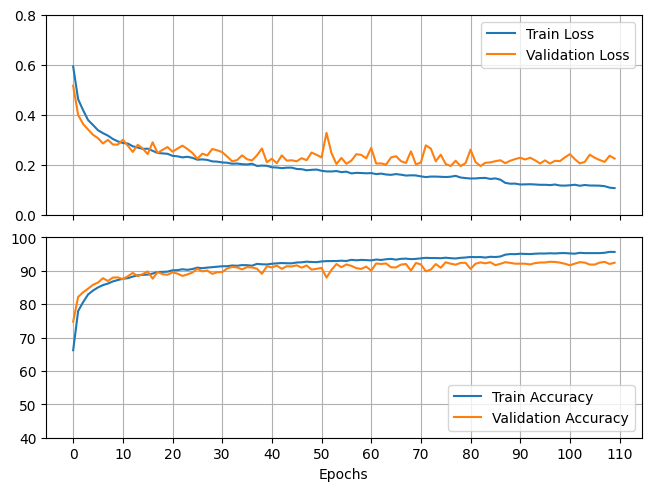

In [40]:
fig, axs = plt.subplots(2, 1,sharex=axs[1])

axs[0].plot(range(len(tr_loss_lst)), tr_loss_lst, label='Train Loss')
axs[0].plot(range(len(val_loss_lst)), val_loss_lst, label='Validation Loss')
axs[0].set_ylim([0, 0.8])

axs[1].plot(range(len(tr_acc_lst)), tr_acc_lst, label='Train Accuracy')
axs[1].plot(range(len(val_acc_lst)), val_acc_lst, label='Validation Accuracy')
axs[1].set_ylim([40, 100])

axs[0].legend(loc='upper right')
axs[1].legend(loc='lower right')

axs[0].grid(True)
axs[1].grid(True)

axs[1].set_xlabel('Epochs')

axs[1].set_xticks(np.arange(0, len(val_acc_lst)+1, step=10))

plt.show()

In [41]:
print(f"Best Validation Accuracy is: {best_acc:.2f}%")

Best Validation Accuracy is: 92.71%


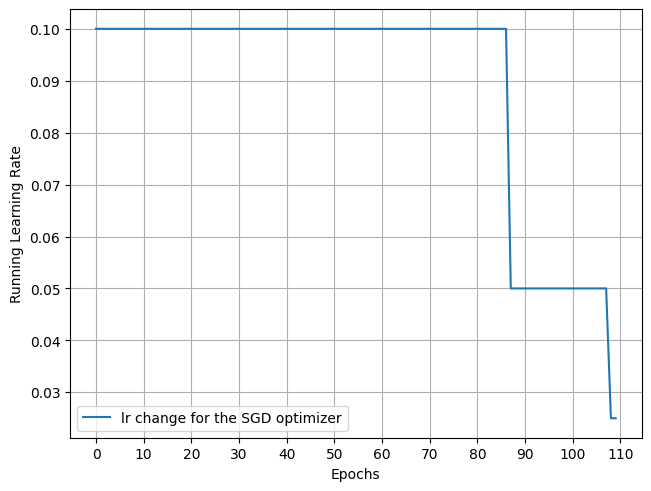

In [42]:
fig, axs = plt.subplots(1, 1)

axs.plot(range(len(running_lr_lst)), running_lr_lst,
         label=f'lr change for the {optimizer_lst[-1]} optimizer')
axs.set_xlabel('Epochs')
axs.set_ylabel('Running Learning Rate')
axs.set_xticks(np.arange(0, len(running_lr_lst)+1, step=10))
axs.grid(True)
axs.legend()
plt.show()

In [43]:
transform_test = transforms.Compose([
    # transforms.ToTensor(),
    # v2.CenterCrop(size=in_img_size),
    # v2.Resize(size=int(in_img_size/2)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(img_trans_norm_mean, img_trans_norm_std),
])

test_set = Images_Dataset(df_test, transform_test)

test_loader = DataLoader(dataset=test_set,
                         batch_size=test_batch_size,
                         # Drops the last mini batch if less than the batch size (could enhance the model accuracy)
                         drop_last=True,
                         shuffle=False,
                         pin_memory=True,
                         num_workers=NUM_WORKERS)

In [44]:
x_test = []
y_pred = []
y_true = []

# iterate over test data
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)

        x_test.extend(inputs.permute(0, 2, 3, 1).to('cpu').numpy())  # save inputs (ready for plot)
        y_pred.extend(predicted.data.to('cpu').numpy())  # Save Prediction
        y_true.extend(labels.data.to('cpu').numpy())  # Save Truth

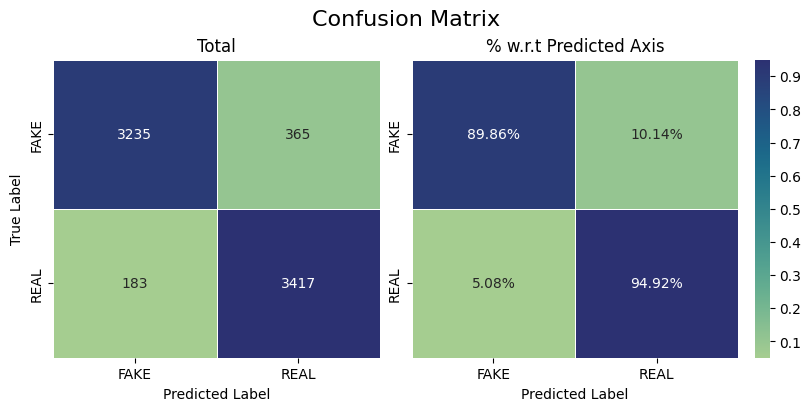

In [45]:
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
CM_df = pd.DataFrame(cf_matrix, index=[i for i in classes],
                     columns=[i for i in classes])

CM_recall = cf_matrix / np.sum(cf_matrix, axis=1)[:, None]
#Using [:,None] to slice a numpy row vector will turn it into column vector
CM_recall_df = pd.DataFrame(CM_recall, index=[i for i in classes],
                            columns=[i for i in classes])

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

g1 = sn.heatmap(CM_df, annot=True, fmt=".0f", linewidth=.5,
                cmap="crest", ax=axs[0], cbar=False)
g1.set(xlabel="Predicted Label", ylabel="True Label")
g1.set_title("Total")

g2 = sn.heatmap(CM_recall_df, annot=True, fmt=".2%",
                linewidth=.5, cmap="crest", ax=axs[1])
g2.set(xlabel="Predicted Label", ylabel="")
g2.set_title("% w.r.t Predicted Axis")
fig.suptitle("Confusion Matrix", fontsize=16)
plt.show()

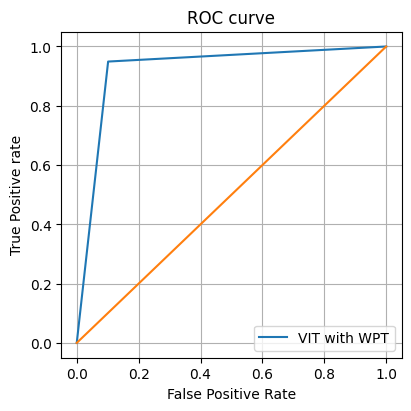

In [46]:
fpr,tpr,threshold=roc_curve(y_true,y_pred)
random_probs = [0 for i in range(len(y_true))]
p_fpr, p_tpr, _ = roc_curve(y_true, random_probs, pos_label=1)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='VIT with WPT')
plt.plot(p_fpr, p_tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

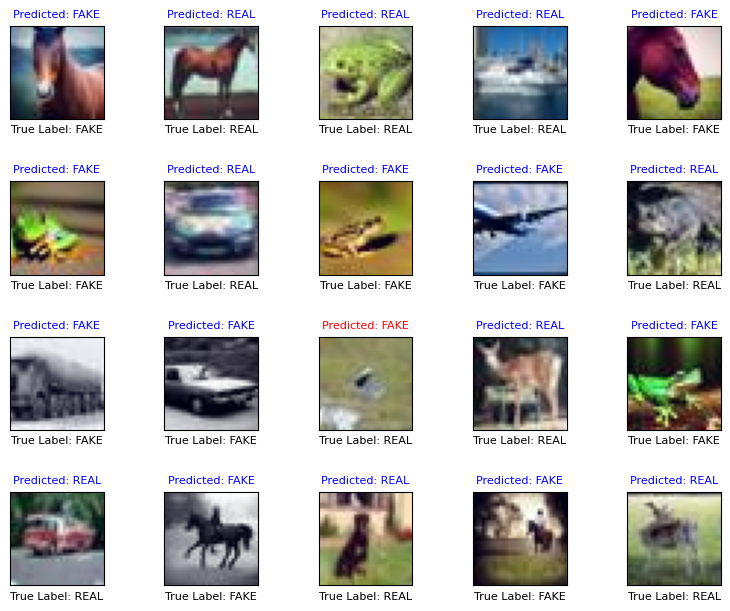

In [47]:
start_idx = 40
sample_length = 20
cols = 5

test_idxs = range(start_idx, start_idx+sample_length)
rows = -(-sample_length//cols)
# print(rows)

figsize = (cols*1.5, rows*1.5)


margins = {  #inches
    "left":   1.0,
    "bottom": 1.0,
    "right":  1.1,
    "top":    1.1,
    "wspace": 0.2,
    "hspace": 0.2
}

fig, axs = plt.subplots(rows,cols, figsize=figsize, gridspec_kw=margins)

for i, ax_row in enumerate(axs):
    for j, ax in enumerate(ax_row):
        idx = test_idxs[i*cols+j]

        tst_img = x_test[idx]
        true_label = classes[y_true[idx]]
        pred_label = classes[y_pred[idx]]
        if pred_label == true_label:
            color = 'b'
        else:
            color = 'r'

        true_label_txt = f'True Label: {true_label}'
        pred_label_txt = f'Predicted: {pred_label}'

        ax.imshow(norm_to_plot(tst_img)[1])
        ax.set_title(pred_label_txt, fontsize=8, color=color)
        ax.set_xlabel(true_label_txt, fontsize=8)
        ax.set(xticks=[], yticks=[])
plt.show()

In [48]:
sample_test_imgt_bch, sample_test_label_bch = next(iter(test_loader))

In [49]:
# a dict to store the activations
activation = {}
def getActivation(name):
  # the hook signature
  def hook(model, input, output):
    activation[name] = output.detach()
  return hook

In [50]:
# model.transformer.layers[1]

In [51]:
h=model.transformer.layers[1][0].fn.softmax.register_forward_hook(getActivation('weights'))

test_output = model(sample_test_imgt_bch.to(device))

In [52]:
index = 10

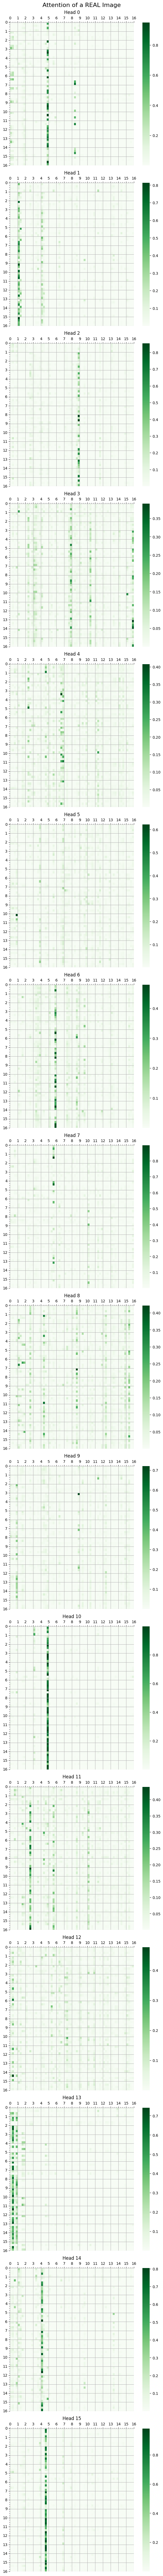

In [53]:
heads = attention_heads
cols = 1
rows = int(heads/cols)
fig, axs = plt.subplots(rows, cols, figsize=(
    cols*6, rows*6), sharex=True, sharey=True)
fig.suptitle(
    f"Attention of a {classes[sample_test_label_bch[index]]} Image", fontsize=16)
for i in range(rows):
    for j in range(cols):
        head = i*cols+j
        mat = activation['weights'][index, head, 1:, 1:].to('cpu').numpy()

        if rows == 1:
            ax = axs[j]
        elif cols == 1:
            ax = axs[i]
        else:
            ax = axs[i][j]

        # ax.imshow(mat, cmap='Greens')
        sn.heatmap(mat, ax=ax, cmap='Greens')
        # sn.heatmap(mat, ax=ax, cbar=False, cmap='magma')
        # sn.heatmap(mat, ax=ax, cbar=False, cmap='ocean')
        # sn.heatmap(mat, ax=ax, cbar=False, cmap='autumn')

        ax.set_title(f"Head {head}")

        ax.set_yticks(np.arange(0, mat.shape[-1]+4, step=4), minor=False)
        ax.set_xticks(np.arange(0, mat.shape[-1]+4, step=4), minor=False)

        ax.set_xticklabels(
            np.arange(0, (mat.shape[-1]+4)//4), minor=False, rotation=0)
        ax.set_yticklabels(
            np.arange(0, (mat.shape[-1]+4)//4), minor=False, rotation=0)

        ax.xaxis.set_ticks_position('top')
        ax.grid(True, which='major')
        ax.minorticks_on()

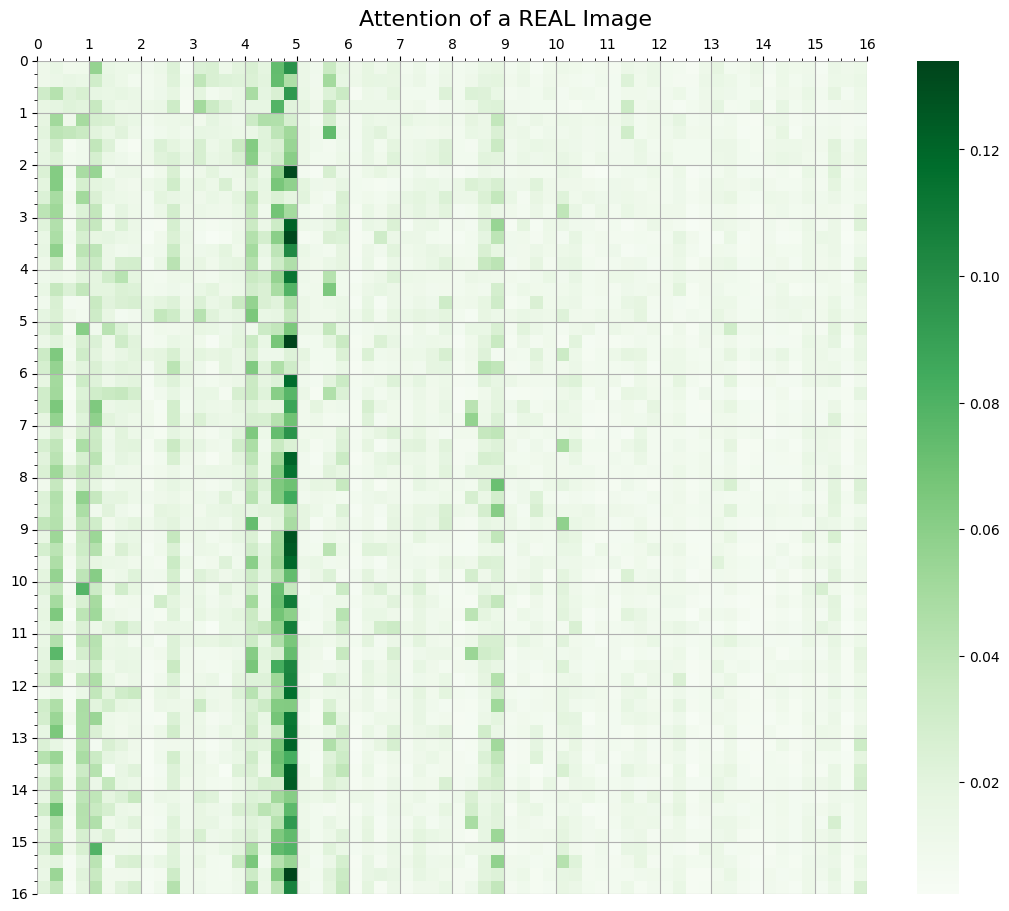

In [54]:
mat2 = activation['weights'][index, :, 1:, 1:].to('cpu').mean(0).numpy()

fig, ax = plt.subplots(1, 1, figsize=(10, 9))
sn.heatmap(mat2, ax=ax,  cmap='Greens')

fig.suptitle(
    f"Attention of a {classes[sample_test_label_bch[index]]} Image", fontsize=16)

ax.set_yticks(np.arange(0, mat.shape[-1]+4, step=4), minor=False)
ax.set_xticks(np.arange(0, mat.shape[-1]+4, step=4), minor=False)

ax.set_xticklabels(np.arange(0, (mat.shape[-1]+4)//4), minor=False, rotation=0)
ax.set_yticklabels(np.arange(0, (mat.shape[-1]+4)//4), minor=False, rotation=0)

ax.xaxis.set_ticks_position('top')
ax.grid(True, which='major')
ax.minorticks_on()

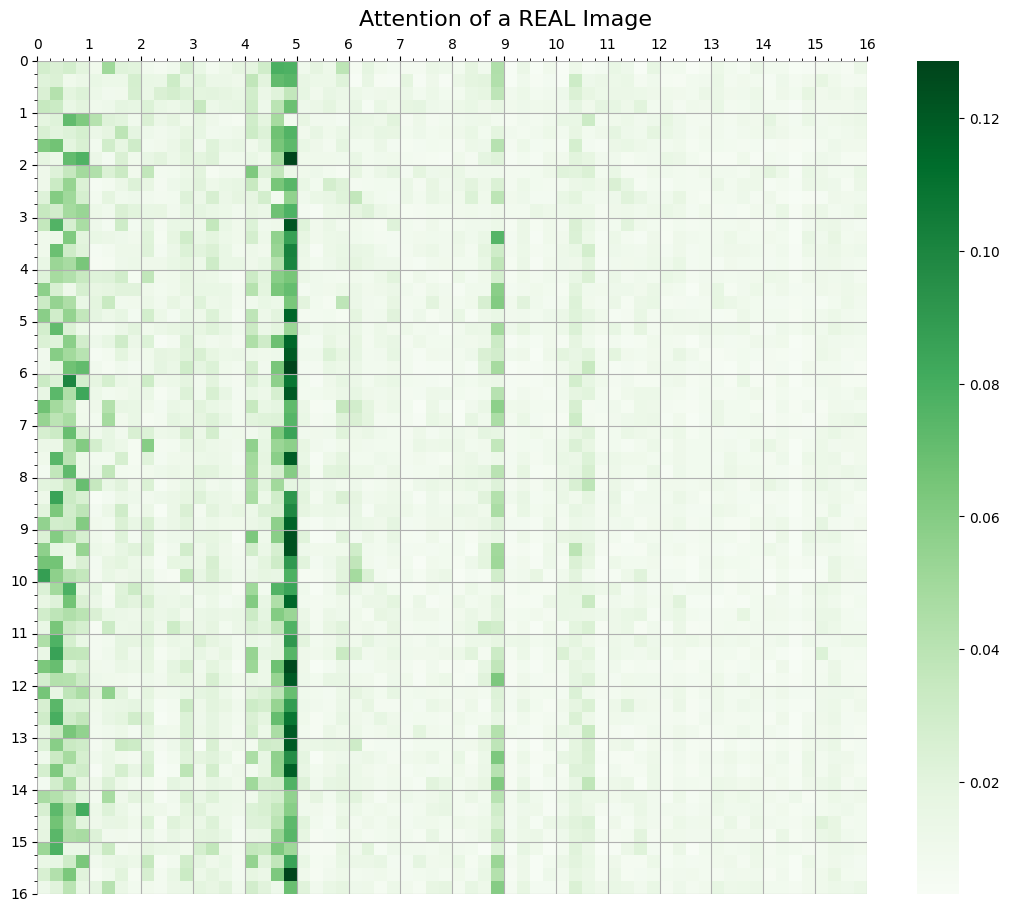

In [55]:
index = 2
mat2 = activation['weights'][index, :, 1:, 1:].to('cpu').mean(0).numpy()

fig, ax = plt.subplots(1, 1, figsize=(10, 9))
sn.heatmap(mat2, ax=ax,  cmap='Greens')

fig.suptitle(
    f"Attention of a {classes[sample_test_label_bch[index]]} Image", fontsize=16)

ax.set_yticks(np.arange(0, mat.shape[-1]+4, step=4), minor=False)
ax.set_xticks(np.arange(0, mat.shape[-1]+4, step=4), minor=False)

ax.set_xticklabels(np.arange(0, (mat.shape[-1]+4)//4), minor=False, rotation=0)
ax.set_yticklabels(np.arange(0, (mat.shape[-1]+4)//4), minor=False, rotation=0)

ax.xaxis.set_ticks_position('top')
ax.grid(True, which='major')
ax.minorticks_on()

In [56]:
# I'm using 16 heads , while the original embedding size of flattened patches is 16 RGB pixels
# hence each head will compute the attention of a single RGB pixel
# every minor tick represent an image patch, and every major tick represents 
# one of the WPT decompositions of a sample test image. 
# By taking mean of the 16 heads attentions, we measure the attention between each patch and
# all of its spatial neighbors, at the same time we measure attention with patches from other 
# wavelet decompositions.
# Result shows that a high attention could be found between patches from different WPT decompositions.

